# Unified Model with Multiple Strategic Agents: Real Data Example

### Different alpha weights

James Yu, 20 February 2025, updated 23 February 2025

In [1]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import us
np.set_printoptions(suppress=True)

In [2]:
def M(K, B, R, L, delta):
    """Computes M_{t-1} given B_l \forall l, K_t^l \forall l, 
        R_l \forall l, number of strategic agents L, and delta."""
    # handle the generic structure first, with the correct pairings:
    base = [[B[l_prime].T @ K[l_prime] @ B[l] for l in range(L)] for l_prime in range(L)]
    # then change the diagonals to construct M_{t-1}:
    for l in range(L): base[l][l] = B[l].T @ K[l] @ B[l] + R[l]/delta
    return np.block(base)

def H(B, K, A, L):
    """Computes H_{t-1} given B_l \forall l, K_t^l \forall l, 
        A, and number of strategic agents L."""
    return np.concatenate(tuple(B[l].T @ K[l] @ A for l in range(L)), axis = 0)

def C_l(A, B, K, k, h, L, c, x, n):
    """Computes C_{t-1}^h (displayed as C_{t-1}^l) given A, B_l \forall l, K_t^l \forall l, 
        k_t^l \forall l, a specific naive agent h, number of strategic agents L, 
        c_l \forall l, x_l \forall l, and number of naive agents n"""
    return np.concatenate(tuple(B[l].T @ K[l] @ A @ ((x[h] - x[l]) * np.ones((n, 1))) 
                           + B[l].T @ K[l] @ c[l] 
                           + 0.5 * B[l].T @ k[l].T for l in range(L)), axis = 0)

def E(M_, H_):
    """Computes the generic E_{t-1} given M_{t-1} and H_{t-1}."""
    return np.linalg.inv(M_) @ H_

def F(M_, C_l_, l, n):
    """Computes F_{t-1}^l given M_{t-1}, C_{t-1}^l, 
       specific naive agent l and number of naive agents n."""
    return (np.linalg.inv(M_) @ C_l_)[l*n:(l+1)*n, :] # e.g. l = 0 gives ln = 0, l = 1 gives ln = n, etc

def G(A, B, E_, L, n):
    """Computes the generic G_{t-1} given A, B_l \forall l, 
        E_{t-1}, number of strategic agents L, and number of naive agents n."""
    return A - sum([B[l] @ E_[l*n:(l+1)*n, :] for l in range(L)])
    
def g_l(B, E_, h, x, F_, L, n, c):
    """Computes g_{t-1}^l given B_l \forall l, E_{t-1}^l, 
        a particular naive agent h, x_l \forall l, F_{t-1}^l \forall l, 
        number of strategic agents L, number of naive agents n, and c_h."""
    return - sum([B[l] @ (E_[l*n:(l+1)*n, :] @ ((x[h] - x[l]) * np.ones((n, 1))) + F_[l]) for l in range(L)]) + c[h]

In [3]:
def K_t_minus_1(Q, K, E_, R, G_, L, delta, n):
    return [Q[l] + E_[l*n:(l+1)*n, :].T @ R[l] @ E_[l*n:(l+1)*n, :] 
            + delta * G_.T @ K[l] @ G_ for l in range(L)]

def k_t_minus_1(K, k, G_, g, E_, F_, R, L, delta, n):
    return [2*delta* g[l].T @ K[l] @ G_ + delta * k[l] @ G_ 
            + 2 * F_[l].T @ R[l] @ E_[l*n:(l+1)*n, :] for l in range(L)]

def kappa_t_minus_1(K, k, kappa, g_, F_, R, L, delta):            
    return [-delta * (g_[l].T @ K[l] @ g_[l] + k[l] @ g_[l] - kappa[l]) 
            - (F_[l].T @ R[l] @ F_[l]) for l in range(L)]

In [4]:
def solve(K_t, k_t, kappa_t, A, B, delta, n, L, Q, R, x, c, tol = 300):
    historical_K = [K_t]
    historical_k = [k_t]
    historical_kappa = [kappa_t]
    max_distances = defaultdict(list)
    counter = 0
    while True:
        M_ = M(K_t, B, R, L, delta)
        H_ = H(B, K_t, A, L)
        E_ = E(M_, H_)
        G_ = G(A, B, E_, L, n)
        K_new = K_t_minus_1(Q, K_t, E_, R, G_, L, delta, n)
        F_ = [F(M_, C_l(A, B, K_t, k_t, l, L, c, x, n), l, n) for l in range(L)]
        g = [g_l(B, E_, h, x, F_, L, n, c) for h in range(L)]
        k_new = k_t_minus_1(K_t, k_t, G_, g, E_, F_, R, L, delta, n)
        kappa_new = kappa_t_minus_1(K_t, k_t, kappa_t, g, F_, R, L, delta)
        cd_K = [np.max(np.abs(K_t[l] - K_new[l])) for l in range(L)]
        cd_k = [np.max(np.abs(k_t[l] - k_new[l])) for l in range(L)]
        cd_kappa = [np.max(np.abs(kappa_t[l] - kappa_new[l])) for l in range(L)]
        K_t = K_new
        k_t = k_new
        kappa_t = kappa_new
        historical_K.insert(0, K_t)
        historical_k.insert(0, k_t)
        historical_kappa.insert(0, kappa_t)
        for l in range(L):
            max_distances[(l+1, "K")].append(cd_K[l])
            max_distances[(l+1, "k")].append(cd_k[l])
            max_distances[(l+1, "kappa")].append(cd_kappa[l])
        counter += 1
        if sum(cd_K + cd_k + cd_kappa) == 0 or counter > tol:
            return max_distances, historical_K, historical_k, historical_kappa

In [5]:
def optimal(X_init, historical_K, historical_k, historical_kappa, A, B, delta, n, L, Q, R, x, c, infinite = True):
    X_t = [a.copy() for a in X_init]
    xs = defaultdict(list)
    for l in range(L):
        xs[l].append(X_t[l])
        
    rs = defaultdict(list)
    payoffs = defaultdict(list)
    payoff = defaultdict(lambda: 0)
    i = 0
    while [i < len(historical_K), True][infinite]:
        K_t = historical_K[[i, 0][infinite]]
        k_t = historical_k[[i, 0][infinite]]
        M_ = M(K_t, B, R, L, delta)
        H_ = H(B, K_t, A, L)
        E_ = E(M_, H_)
        G_ = G(A, B, E_, L, n)
        F_ = [F(M_, C_l(A, B, K_t, k_t, l, L, c, x, n), l, n) for l in range(L)]
        g = [g_l(B, E_, h, x, F_, L, n, c) for h in range(L)]
        for l in range(L):
            # TODO: special code for finite horizon needs a terminal time T term
            Y_new = -1 * E_[l*n:(l+1)*n, :] @ X_t[l] - F(M_, C_l(A, B, K_t, k_t, l, L, c, x, n), l, n)
            rs[l].append(Y_new)
            payoff[l] += (-1 * delta**i * (X_t[l].T @ Q[l] @ X_t[l])).item() + (-1 * delta**i * (Y_new.T @ R[l] @ Y_new)).item()
            payoffs[l].append(payoff[l])
            X_new = G_ @ X_t[l] + g[l]
            xs[l].append(X_new)
            if infinite == True and np.max(X_t[l] - X_new) == 0 and l == L - 1:
                return xs, rs, payoffs
            X_t[l] = X_new 
        i += 1
        
    return xs, rs, payoffs

In [6]:
def run_simulation(A, X_0_1, b2, a1, a2):
    X_0 = [X_0_1, X_0_1 - b2]
    delta = 0.9 # discount rate
    c_cost = 1 # message cost
    n = X_0_1.shape[0] # number of naive agents
    L = 2 # number of strategic agents
    Q = [np.identity(n), np.identity(n)] # objective function for messages is just X'IX = X'X
    R = [c_cost * np.identity(n), c_cost * np.identity(n)] # message cost R = cI_n for some c under the new notation
    B = [a1 * np.identity(n), a2 * np.identity(n)] # B^l = a_l I_n
    x = [0, b2] # agendas
    r = [0, 0] # message cost minimality is centered around zero
    c_base = sum([B[l] @ (r[l] * np.ones((n, 1))) for l in range(L)])
    c = [c_base + (A - np.identity(n)) @ (x[l] * np.ones((n, 1))) for l in range(L)] # normalization vector
    max_distances, historical_K, historical_k, historical_kappa = solve(Q, [np.zeros((1, n)), np.zeros((1, n))], [0, 0], A, B, delta, n, L, Q, R, x, c, tol = 1000)
    xs, rs, payoffs = optimal(X_0, historical_K, historical_k, historical_kappa, A, B, delta, n, L, Q, R, x, c)
    return xs[0], rs, payoffs
    #print(xs[0][-1])
    

In [7]:
network_matrix = pd.read_csv("state_net_adjacency.csv")

In [8]:
state_label_list = list(network_matrix.columns[1:])
state_name_list = []
for state_label in state_label_list:
    if state_label == "DC":
        state_name_list.append("District of Columbia")
    else:
        state_name_list.append(us.states.lookup(state_label).name)

In [9]:
initial_x_data = pd.read_csv("YCOM7_publicdata.csv")

In [10]:
state_opinion_map = {}
for row in initial_x_data.iterrows():
    if row[1]["geoname"] in state_name_list:
        state_opinion_map[row[1]["geoname"]] = row[1]["consensusOppose"]

state_opinion_map

{'Alabama': 27.95,
 'Alaska': 24.83,
 'Arizona': 25.04,
 'Arkansas': 28.93,
 'California': 20.41,
 'Colorado': 23.02,
 'Connecticut': 21.35,
 'Delaware': 23.52,
 'District of Columbia': 15.46,
 'Florida': 24.26,
 'Georgia': 23.67,
 'Hawaii': 21.37,
 'Idaho': 29.87,
 'Illinois': 22.39,
 'Indiana': 29.06,
 'Iowa': 27.53,
 'Kansas': 27.95,
 'Kentucky': 30.16,
 'Louisiana': 25.9,
 'Maine': 24.72,
 'Maryland': 19.4,
 'Massachusetts': 19.85,
 'Michigan': 24.59,
 'Minnesota': 23.85,
 'Mississippi': 26.22,
 'Missouri': 27.57,
 'Montana': 28.45,
 'Nebraska': 28.35,
 'Nevada': 25.28,
 'New Hampshire': 24.29,
 'New Jersey': 20.85,
 'New Mexico': 25.35,
 'New York': 20.08,
 'North Carolina': 24.11,
 'North Dakota': 32.61,
 'Ohio': 26.76,
 'Oklahoma': 30.14,
 'Oregon': 22.67,
 'Pennsylvania': 24.49,
 'Rhode Island': 23.9,
 'South Carolina': 26.28,
 'South Dakota': 29.46,
 'Tennessee': 28.29,
 'Texas': 24.77,
 'Utah': 28.69,
 'Vermont': 22.07,
 'Virginia': 22.33,
 'Washington': 21.7,
 'West Virginia

In [11]:
X_0_1_data = []
# iterate over the states as ordered in the matrix 
# to ensure the initial opinions have the same order
for state_label in state_label_list:
    if state_label == "DC":
        state_name = "District of Columbia"
    else:
        state_name = us.states.lookup(state_label).name
    X_0_1_data.append(state_opinion_map[state_name])

print(X_0_1_data) # the initial opinions

[24.83, 27.95, 28.93, 25.04, 20.41, 23.02, 21.35, 15.46, 23.52, 24.26, 23.67, 21.37, 27.53, 29.87, 22.39, 29.06, 27.95, 30.16, 25.9, 19.85, 19.4, 24.72, 24.59, 23.85, 27.57, 26.22, 28.45, 24.11, 32.61, 28.35, 24.29, 20.85, 25.35, 25.28, 20.08, 26.76, 30.14, 22.67, 24.49, 23.9, 26.28, 29.46, 28.29, 24.77, 28.69, 22.33, 22.07, 21.7, 25.9, 33.71, 33.24]


In [12]:
X_0_1_numpy = np.array([X_0_1_data], ndmin = 2).T

In [13]:
A_data = network_matrix.to_numpy()[:, 1:].astype(np.float64)

In [14]:
A_data

array([[0.45950087, 0.00698945, 0.00479319, ..., 0.0091629 , 0.00203207,
        0.00300008],
       [0.00057838, 0.68728663, 0.00356649, ..., 0.00252862, 0.00111391,
        0.00034574],
       [0.00075465, 0.0067856 , 0.64754348, ..., 0.00402283, 0.00094993,
        0.00065503],
       ...,
       [0.00096402, 0.00321485, 0.00268821, ..., 0.65677675, 0.00076099,
        0.00075061],
       [0.00060578, 0.00401288, 0.00179866, ..., 0.00215628, 0.60770641,
        0.00050837],
       [0.00316044, 0.00440139, 0.00438285, ..., 0.00751585, 0.00179647,
        0.44020426]])

In [15]:
A_data[0, :] # first row

array([0.45950087, 0.00698945, 0.00479319, 0.02110471, 0.05543452,
       0.01966996, 0.00274554, 0.00130255, 0.00101112, 0.0261343 ,
       0.01459634, 0.01004995, 0.0041367 , 0.01223794, 0.0110416 ,
       0.00670229, 0.00479014, 0.00463437, 0.00626128, 0.00606396,
       0.00588541, 0.00288865, 0.01252192, 0.01262544, 0.00881115,
       0.00385955, 0.00864238, 0.01431582, 0.0027795 , 0.00338347,
       0.00200501, 0.00539467, 0.00511521, 0.00960488, 0.01468289,
       0.01113458, 0.0074019 , 0.02484694, 0.01215497, 0.00091786,
       0.00742014, 0.00261015, 0.00986565, 0.03868826, 0.01326547,
       0.01205095, 0.0013753 , 0.05235607, 0.0091629 , 0.00203207,
       0.00300008])

In [16]:
A_data[:, 0] # first column

array([0.45950087, 0.00057838, 0.00075465, 0.00201949, 0.00110587,
       0.00206204, 0.00048504, 0.00076749, 0.00057339, 0.0007869 ,
       0.00063218, 0.00464912, 0.00077263, 0.00437934, 0.0004828 ,
       0.00056973, 0.00099685, 0.00054648, 0.00054072, 0.0005498 ,
       0.00057357, 0.00144352, 0.00073689, 0.00137427, 0.00077227,
       0.00044432, 0.00478749, 0.00067754, 0.00209138, 0.00102601,
       0.00101943, 0.00039696, 0.00155755, 0.00214323, 0.00043819,
       0.00053619, 0.00105967, 0.00442524, 0.00055459, 0.00053283,
       0.00060787, 0.0016853 , 0.00068097, 0.00080354, 0.00227411,
       0.0007841 , 0.00141126, 0.00497437, 0.00096402, 0.00060578,
       0.00316044])

In [17]:
A_data.shape

(51, 51)

In [18]:
xs, rs, payoffs = run_simulation(A_data, X_0_1_numpy, 50, 1, 2)

In [19]:
xs[-1].T # steady-state opinions

array([[42.98330892, 46.06107028, 44.97603331, 46.61155793, 57.91256095,
        46.5962252 , 44.81070399, 42.46723761, 43.01448761, 52.38261628,
        48.85145795, 43.4516433 , 45.12513889, 43.98125528, 49.23882047,
        46.11559856, 44.55230058, 45.39888471, 45.97961071, 48.03350509,
        46.64056547, 43.96026557, 47.27753629, 47.03204865, 46.69618762,
        45.38008919, 43.79180359, 48.65063457, 43.41617613, 44.57998202,
        43.5686402 , 46.53431706, 44.04764218, 44.1430726 , 51.85508527,
        48.3562175 , 45.28050474, 44.99375345, 49.23311351, 43.29917085,
        46.11307477, 43.80716605, 46.96881728, 55.71786443, 45.52143417,
        47.69696096, 43.07433716, 47.11714836, 45.95683278, 44.01117131,
        42.97324443]])

In [20]:
for i, entry in enumerate((xs[-1].T)[0]):
    if entry > 50:
        print(i, state_label_list[i], us.states.lookup(state_label_list[i]).name, entry, A_data[i, i])

4 CA California 57.91256095440611 0.6638204880397075
9 FL Florida 52.382616279848435 0.5680755040285697
34 NY New York 51.855085267332576 0.647401219965992
43 TX Texas 55.71786443267107 0.6871549621856287


In [21]:
state_label_list

['AK',
 'AL',
 'AR',
 'AZ',
 'CA',
 'CO',
 'CT',
 'DC',
 'DE',
 'FL',
 'GA',
 'HI',
 'IA',
 'ID',
 'IL',
 'IN',
 'KS',
 'KY',
 'LA',
 'MA',
 'MD',
 'ME',
 'MI',
 'MN',
 'MO',
 'MS',
 'MT',
 'NC',
 'ND',
 'NE',
 'NH',
 'NJ',
 'NM',
 'NV',
 'NY',
 'OH',
 'OK',
 'OR',
 'PA',
 'RI',
 'SC',
 'SD',
 'TN',
 'TX',
 'UT',
 'VA',
 'VT',
 'WA',
 'WI',
 'WV',
 'WY']

In [22]:
for state_label in state_label_list:
    if state_label == "DC":
        state_name = "District of Columbia"
    else:
        state_name = us.states.lookup(state_label).name
    print(state_name)

Alaska
Alabama
Arkansas
Arizona
California
Colorado
Connecticut
District of Columbia
Delaware
Florida
Georgia
Hawaii
Iowa
Idaho
Illinois
Indiana
Kansas
Kentucky
Louisiana
Massachusetts
Maryland
Maine
Michigan
Minnesota
Missouri
Mississippi
Montana
North Carolina
North Dakota
Nebraska
New Hampshire
New Jersey
New Mexico
Nevada
New York
Ohio
Oklahoma
Oregon
Pennsylvania
Rhode Island
South Carolina
South Dakota
Tennessee
Texas
Utah
Virginia
Vermont
Washington
Wisconsin
West Virginia
Wyoming


In [23]:
print("LIMIT OPINIONS BY STATE:")

for i, entry in enumerate((xs[-1].T)[0]):
    if state_label_list[i] == "DC":
        lookup_name = "District of Columbia"
    else:
        lookup_name = us.states.lookup(state_label_list[i]).name
    print(i, state_label_list[i], lookup_name, entry)

LIMIT OPINIONS BY STATE:
0 AK Alaska 42.983308922399424
1 AL Alabama 46.06107027677622
2 AR Arkansas 44.97603330674369
3 AZ Arizona 46.611557934317425
4 CA California 57.91256095440611
5 CO Colorado 46.59622519657509
6 CT Connecticut 44.810703991551875
7 DC District of Columbia 42.46723761329619
8 DE Delaware 43.01448760829383
9 FL Florida 52.382616279848435
10 GA Georgia 48.851457946064976
11 HI Hawaii 43.45164329675116
12 IA Iowa 45.12513889496101
13 ID Idaho 43.98125527852601
14 IL Illinois 49.238820472802004
15 IN Indiana 46.11559855700931
16 KS Kansas 44.55230057903567
17 KY Kentucky 45.39888470568154
18 LA Louisiana 45.979610705770234
19 MA Massachusetts 48.03350509226847
20 MD Maryland 46.64056547211446
21 ME Maine 43.96026557100083
22 MI Michigan 47.27753628635007
23 MN Minnesota 47.032048650085095
24 MO Missouri 46.69618762452662
25 MS Mississippi 45.380089187603964
26 MT Montana 43.79180358924735
27 NC North Carolina 48.650634566916054
28 ND North Dakota 43.41617612684518
29 

In [24]:
len(xs) # time periods before convergence

23

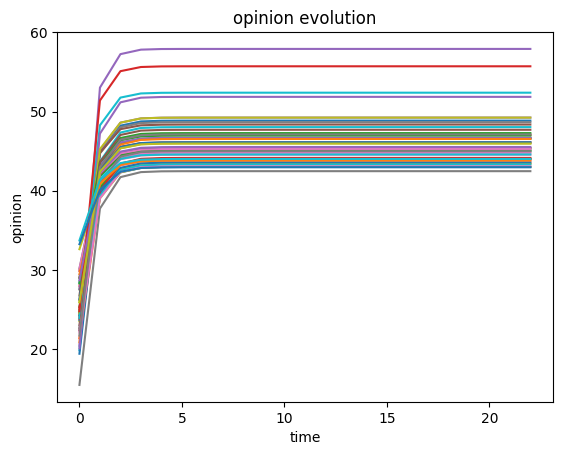

In [25]:
time_grid = range(len(xs))

for state in range(51):
    plt.plot(time_grid, [xs[t][state, 0] for t in time_grid])

plt.xlabel("time")
plt.ylabel("opinion")
plt.title("opinion evolution")
plt.show()

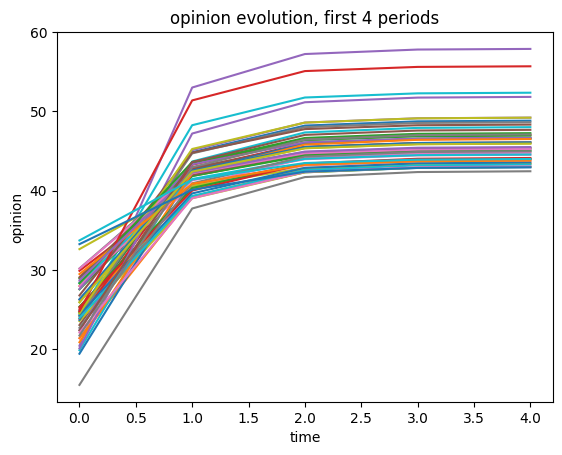

In [26]:
time_grid_short = range(5)
for state in range(51):
    plt.plot(time_grid_short, [xs[t][state, 0] for t in time_grid_short])

plt.xlabel("time")
plt.ylabel("opinion")
plt.title("opinion evolution, first 4 periods")
plt.show()

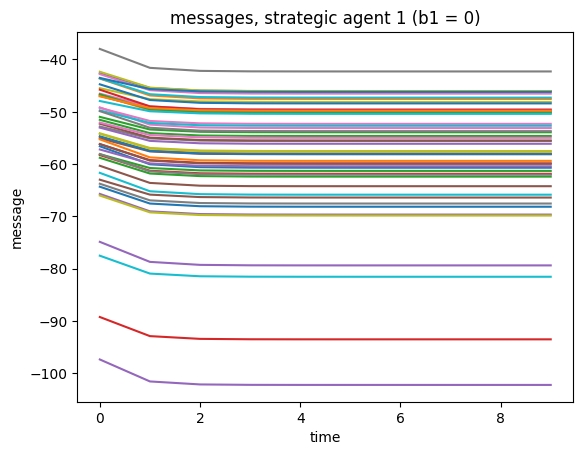

In [27]:
time_grid = range(10)
for state in range(51):
    plt.plot(time_grid, [rs[0][t][state, 0] for t in time_grid])

plt.xlabel("time")
plt.ylabel("message")
plt.title("messages, strategic agent 1 (b1 = 0)")
plt.show()

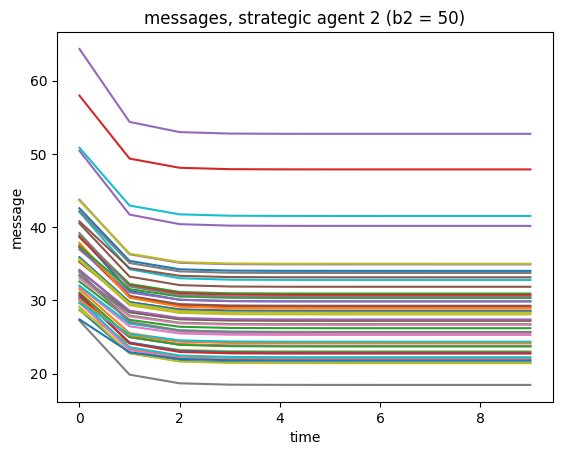

In [28]:
time_grid = range(10)
for state in range(51):
    plt.plot(time_grid, [rs[1][t][state, 0] for t in time_grid])

plt.xlabel("time")
plt.ylabel("message")
plt.title("messages, strategic agent 2 (b2 = 50)")
plt.show()

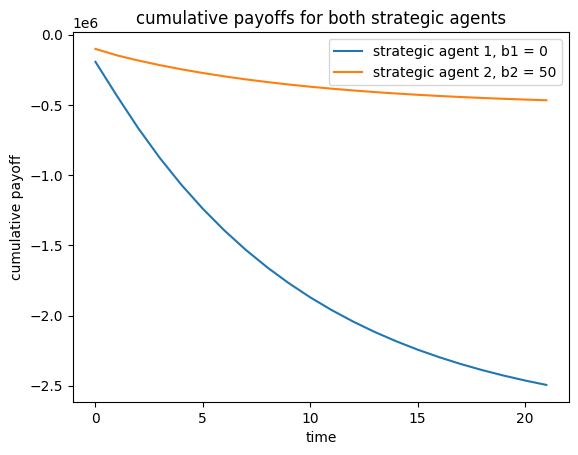

In [29]:
plt.plot(range(len(payoffs[0])), payoffs[0], label = "strategic agent 1, b1 = 0")
plt.plot(range(len(payoffs[1])), payoffs[1], label = "strategic agent 2, b2 = 50")
plt.xlabel("time")
plt.ylabel("cumulative payoff")
plt.title("cumulative payoffs for both strategic agents")
plt.legend()
plt.show()

### NOTE: The labels on the above plot's y-axis should be multiplied by $10^6$ to be interpreted.

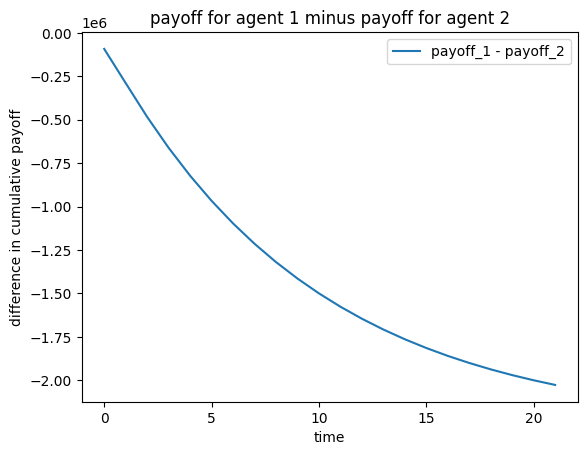

In [30]:
plt.plot(range(len(payoffs[0])), [payoffs[0][i] - payoffs[1][i] for i in range(len(payoffs[0]))], label = "payoff_1 - payoff_2")
plt.xlabel("time")
plt.ylabel("difference in cumulative payoff")
plt.legend()
plt.title("payoff for agent 1 minus payoff for agent 2")
plt.show()

### NOTE: The labels on the above plot's y-axis should be multiplied by $10^6$ to be interpreted.

In [31]:
# OPINIONS
for i, opinion_vec in enumerate(xs):
    print(f"t = {i}:", opinion_vec.T)

t = 0: [[24.83 27.95 28.93 25.04 20.41 23.02 21.35 15.46 23.52 24.26 23.67 21.37
  27.53 29.87 22.39 29.06 27.95 30.16 25.9  19.85 19.4  24.72 24.59 23.85
  27.57 26.22 28.45 24.11 32.61 28.35 24.29 20.85 25.35 25.28 20.08 26.76
  30.14 22.67 24.49 23.9  26.28 29.46 28.29 24.77 28.69 22.33 22.07 21.7
  25.9  33.71 33.24]]
t = 1: [[39.27298134 42.77626545 41.85125161 42.7320404  53.02309483 42.61505894
  40.59848488 37.74359981 39.03050186 48.26381279 44.853249   39.23874433
  41.8487129  40.71184103 45.11617613 42.90955576 41.30037306 42.47155854
  42.38808297 43.67736399 42.32735336 40.29530003 43.49704461 43.26688673
  43.32562355 41.98793067 40.57471289 44.70324323 40.61217364 41.46702494
  39.64910834 42.18037067 40.34223463 40.0043073  47.21098549 44.79463857
  42.19700729 40.92035275 45.2604602  39.31973181 42.53386065 40.86761846
  43.61811431 51.39658623 42.26587484 43.60258832 39.0454149  42.96190359
  42.39871789 41.40191035 40.1062619 ]]
t = 2: [[42.31774564 45.48933569 44.4

In [32]:
# MESSAGES
for i in range(len(rs[0])):
    print(f"t = {i}:")
    print("  strategic agent 1:", rs[0][i].T)
    print("  strategic agent 2:", rs[1][i].T)
    print()

t = 0:
  strategic agent 1: [[-42.62135379 -54.822764   -50.96820848 -56.17071055 -97.33851098
  -56.16928398 -49.1620194  -37.98095928 -42.34513118 -77.50295668
  -64.315856   -43.63842888 -51.53154829 -46.94045457 -65.69351478
  -55.06671355 -49.24593901 -52.8117376  -54.10333373 -61.66994136
  -56.58847593 -46.82930901 -58.79273645 -58.2691445  -57.20252212
  -52.28736736 -46.53262429 -63.74915246 -45.48850958 -49.7310942
  -44.74651624 -55.26867044 -46.66147723 -45.77638257 -74.85665345
  -62.97602708 -52.05601258 -49.87386565 -66.00485711 -43.59767383
  -54.67836469 -47.04630989 -58.10011443 -89.22261779 -53.02482583
  -60.31457875 -42.79209704 -58.07184372 -54.22786702 -47.93499931
  -43.52411858]]
  strategic agent 2: [[28.6920067  35.32745445 32.5643475  37.19988853 64.34398824 37.50109899
  33.93078843 27.23347636 29.11223022 50.84410125 42.57466645 30.18618212
  33.42414931 30.31536994 43.74231043 35.24016022 31.83335873 33.32506137
  35.4630218  42.06488934 38.82686678 31.53

In [33]:
# CUMULATIVE PAYOFFS
print("        strategic agent 1  strategic agent 2")
for i in range(len(payoffs[0])):
    print(f"t = {i}:", payoffs[0][i], payoffs[1][i])

        strategic agent 1  strategic agent 2
t = 0: -193223.00730345954 -101311.03598962416
t = 1: -435610.548393743 -147038.1593518823
t = 2: -667443.2462170362 -184066.4805681256
t = 3: -878242.3589506956 -216847.0457033381
t = 4: -1068281.6634116038 -246270.95250864868
t = 5: -1239363.7979969182 -272741.0519399536
t = 6: -1393344.4843155174 -296562.4916098043
t = 7: -1531928.075144781 -318001.5500691651
t = 8: -1656653.4463582318 -337296.6686859516
t = 9: -1768906.3003899024 -354662.27058085444
t = 10: -1869933.871864573 -370291.3115925418
t = 11: -1960858.6865976006 -384357.44840414595
t = 12: -2042691.0199151484 -397016.97152049607
t = 13: -2116340.119909176 -408410.542323204
t = 14: -2182624.3099049735 -418664.7560453554
t = 15: -2242280.0809013583 -427893.548395251
t = 16: -2295970.2747981283 -436199.4615101512
t = 17: -2344291.4493052247 -443674.7833135606
t = 18: -2387780.5063616117 -450402.57293662895
t = 19: -2426920.6577123604 -456457.58359739045
t = 20: -2462146.793928034 